In [5]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit

import survivors.datasets as ds

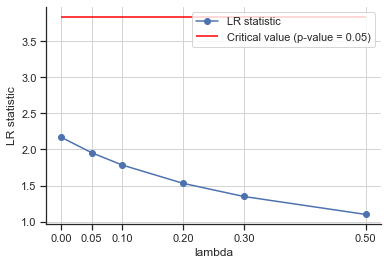

In [28]:
from survivors.tree.find_split_hist import get_sa_hists


def count_log_rank(dur, cens, ind, reg_l=0.0):
    max_bin = dur.max()
    all_time_hist, all_cens_hist = get_sa_hists(dur, cens, minlength=max_bin + 1)
    l_time_hist, l_cens_hist = get_sa_hists(dur[ind], cens[ind], minlength=max_bin + 1)
    r_time_hist, r_cens_hist = all_time_hist - l_time_hist, all_cens_hist - l_cens_hist

    l_time_hist = l_time_hist + reg_l*all_time_hist*0.5
    r_time_hist = r_time_hist + reg_l*all_time_hist*0.5
    l_cens_hist = l_cens_hist + reg_l*all_cens_hist*0.5
    r_cens_hist = r_cens_hist + reg_l*all_cens_hist*0.5

    N_1_j = np.cumsum(l_time_hist[::-1])[::-1]
    N_2_j = np.cumsum(r_time_hist[::-1])[::-1]

    #print(list(N_1_j))  #, l_cens_hist)
    #print(list(N_2_j))  #, r_cens_hist)

    ind = np.where((l_cens_hist + r_cens_hist != 0) & (N_1_j * N_2_j != 0))[0]

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = l_cens_hist[ind]
    O_2_j = r_cens_hist[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j

    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))

    res[:, 0] = 1.0
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()

    stat_val = np.power(num, 2) / var
    #print(list(E_1_j))
    return stat_val, crit.chi2_sf(stat_val, df=1)

dur = np.hstack([np.random.normal(30, 10, 16), np.random.normal(50, 10, 16)]).astype(int) # np.linspace(0, 150, 16, dtype=int)
cens = np.ones_like(dur)
ind1 = np.arange(32)[:20:2]
# ind1 = [0, 1, 2, 3, 7, 8, 9, 10]  # [0, 1, 2, 3]

s = []
p = []
l_s = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]
for l in l_s:
    stat_val, p_val = count_log_rank(dur, cens, ind1, reg_l=l)
    s.append(stat_val)
    p.append(p_val)
plt.plot(l_s, s, label="LR statistic", marker="o")
plt.xticks(l_s)
plt.hlines([crit.chi2_isf(0.05, df=1)], xmin=min(l_s), xmax=max(l_s), color="red", label="Critical value (p-value = 0.05)")
plt.xlabel("lambda")
plt.ylabel("LR statistic")
plt.legend()

In [24]:
np.hstack([np.random.normal(30, 10, 16), np.random.normal(50, 10, 16)]).astype(int)

array([42, 25, 28, 32, 24, 23, 24, 47, 43, 24, 29, 29, 20, 25, 36, 28, 44,
       46, 51, 50, 60, 58, 55, 35, 46, 54, 39, 50, 52, 53, 40, 54])

In [31]:
X, y, f, c, n = ds.load_gbsg_dataset()

In [34]:
x_sub = X.sample(n=100, random_state=42)
x_oob = X.loc[X.index.difference(x_sub.index), :]

In [35]:
x_oob

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
0,0,70,2,21,2,3,48,66
1,1,56,2,12,2,7,61,77
3,1,59,2,17,2,4,60,29
4,0,73,2,35,2,1,26,65
5,0,32,1,57,3,24,0,13
...,...,...,...,...,...,...,...,...
680,1,60,2,40,2,6,8,11
682,1,53,2,25,3,17,0,0
683,0,51,1,25,3,5,43,0
684,0,52,2,23,2,3,15,34


In [36]:
x_sub

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
286,1,57,2,7,2,1,1,1
652,1,50,2,50,2,6,1,2
257,1,51,1,25,2,1,167,109
336,0,38,1,24,2,3,13,5
318,1,51,1,30,3,2,1152,38
...,...,...,...,...,...,...,...,...
182,1,74,2,20,2,1,462,240
164,0,37,1,15,1,1,162,22
628,1,51,2,22,2,4,250,81
356,1,70,2,17,1,1,142,329
